# Проект e-commerce:

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. 

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Файлы:

olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

olist_orders_dataset.csv —  таблица заказов

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара


— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5


Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан

approved —  подтверждён

invoiced —  выставлен счёт

processing —  в процессе сборки заказа

shipped —  отгружен со склада

delivered —  доставлен пользователю

unavailable —  недоступен

canceled —  отменён

In [1]:
import pandas as pd

In [2]:
customers=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-kim-18/1_project/datasets/olist_customers_dataset.csv')
orders=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-kim-18/1_project/datasets/olist_orders_dataset.csv')
order_items=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-kim-18/1_project/datasets/olist_order_items_dataset.csv')

## Задание 1. 
Сколько у нас пользователей, которые совершили покупку только один раз?

In [3]:
# Уникальный идентификатор пользователя указан в таблице 'customers', а данные по заказам в таблице 'orders'.
customers_orders=customers.merge(orders, on='customer_id')
customers_orders.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00


Буду считать "свершившейся покупкой" все оплаченные заказы с указанной датой order_approved_at, за исключением отмененных (деньги, скорее всего, придется вернуть не смотря на то, что заказ уже оплачен) и недоступных (есть вероятность, что заказ так и не станет доступным, а деньги, опять-таки, придется вернуть).

Необходимо понять что значат статусы заказа 'canceled' и 'unavailable'.

In [4]:
# Проверяю, могут ли отмененные заказы быть оплаченными
customers_orders.query("order_status=='canceled'").order_approved_at.nunique()

483

In [5]:
# Проверяю, могут ли недоступные заказы быть оплаченными
customers_orders.query("order_status=='unavailable'").order_approved_at.nunique()

607

In [6]:
# Проверяю наличие пропущенных значений в order_approved_at
customers_orders.order_approved_at.isna().sum()

160

In [7]:
# Удаляю строки с пустыми значениями в колонке 'order_approved_at'.
df1 = customers_orders.query("order_status!='canceled' and order_status!='unavailable'").dropna(subset=['order_approved_at'])
# Считаю сколько покупок совершил каждый уникальный пользователь и отбираю пользователей, совершивших только одну покупку
df1.groupby('customer_unique_id', as_index=False).agg({'order_id':'count'}).rename(columns={'order_id':'orders_count'})\
   .query("orders_count==1").nunique()

customer_unique_id    92087
orders_count              1
dtype: int64

## Ответ: 
92087 пользователей.

## Задание 2. 
Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Предполагаю, что продакт-менеджер Василий под "недоставленными заказами" имел в виду заказы, деньги за которые либо не были получены, либо будут возвращены покупателю, либо только созданы. Так как неотмененные оплаченные заказы, находящиеся на стадии approved/shipped/processing рано или поздно будут доставлены покупателю, то причинами недоставки укажу статусы: canceled/created/invoiced/unavailable. 

Подсчет недоставленных заказов в конкретный месяц веду по признаку "создан"=order_purchase_timestamp в этом месяце.

*Даты годовалых и прочих явно старых, но почему-то не поменявшихся статусов approved/shipped/processing в моем утверждении об итоговой конечной доставке спишем на веру в существование покупателей,готовых ожидать заказ годами или не готовых заниматься возвратом денег :)

In [8]:
# Создаю новую колонку, содержащую месяц и год из колонки order_purchase_timestamp
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_creation'] = orders.order_purchase_timestamp.dt.strftime('%Y-%m')
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_creation
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07


In [9]:
# Детализация причин недоставки
orders.query("order_status=='created'or order_status=='invoiced'or order_status=='unavailable'or order_status=='canceled'")\
      .groupby(['order_creation','order_status'], as_index=False).agg({'order_id':'count'})\
      .rename(columns={'order_id':'undelivered_orders'})\
      .groupby('order_status', as_index=False).agg({'undelivered_orders':'sum'})

,order_status,undelivered_orders
0,canceled,625
1,created,5
2,invoiced,314
3,unavailable,609


In [10]:
# Подсчет количества недоставленных заказов в месяц в среднем
orders.query("order_status=='created'or order_status=='invoiced'or order_status=='unavailable'or order_status=='canceled'")\
      .groupby('order_creation', as_index=False).agg({'order_id':'count'}).rename(columns={'order_id':'undelivered_orders'})\
      .undelivered_orders.mean().round(0)

65.0

## Ответ: 
65 заказов

## Задание 3. 
По каждому товару определить, в какой день недели товар чаще всего покупается.

In [11]:
# Данные по заказам есть в таблице 'orders', а данные по товарам в  'order_items'. 
order_items_and_orders=order_items.merge(orders, on='order_id')
order_items_and_orders.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_creation
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,2017-09
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,2017-04


In [12]:
# Удаляю строки с пустыми значениями в колонке 'order_approved_at'.
df1_1=order_items_and_orders.query("order_status!='canceled' and order_status!='unavailable'").dropna(subset=['order_approved_at'])
# Создадим новую колонку с днем недели заказа товара.
df1_1['weekday'] = df1_1.order_purchase_timestamp.dt.strftime('%A')
df1_1.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_creation,weekday
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,2017-09,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,2017-04,Wednesday


In [13]:
# Создаю колонку 'weekday_count'- сколько раз каждый товар покупался в конкретный день недели
df2=df1_1.groupby(['product_id','weekday'], as_index=False).agg({'price':'count'}).rename(columns={'price':'weekday_count'})
df2.head(2)

,product_id,weekday,weekday_count
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1


Под "чаще всего покупался" буду иметь в виду соответствие следующим условиям:

- покупался в минимум два разных дня недели (чтобы было с чем сравнивать)

- есть разница в количестве между разными днями (соответственно, минимальное общее количество не менее трех)

- берется день с наибольшим количеством (в случае нескольких одинаковых максимальных значений будем считать, что признак "чаще всего покупался" невозможно определить для данного product_id, так как условие превосходства невозможно для равных значений)

In [14]:
# Считаю 'product_sum'- общее количество продаж каждого товара и отбираю те товары, где это количество >=3
df3=df2.groupby('product_id', as_index=False).agg({'weekday_count':'sum'}).rename(columns={'weekday_count':'product_sum'})\
       .query('product_sum>=3').sort_values('product_sum')
df3.head(2)

,product_id,product_sum
16520,80ac250f5bffe3fff8097929c3c4a938,3
7384,3932e37f1f658768ac53fbe680f145bc,3


In [15]:
df4=df2.merge(df3, on='product_id')
df4.head(2)

,product_id,weekday,weekday_count,product_sum
0,001795ec6f1b187d37335e1c4704762e,Monday,2,9
1,001795ec6f1b187d37335e1c4704762e,Saturday,3,9


In [16]:
# Считаю 'weekday_sum'- количество разных наименований дней недели, в которые продавался товар. Далее отбираю товары,
# продававшиеся в минимум два разных дня
df5=df4.merge(df4.groupby('product_id', as_index=False).agg({'weekday':'count'}).rename(columns={'weekday':'weekday_sum'})\
             , on='product_id').query('weekday_sum>1')
# Также исключаю дни, когда во все дни продаж было продано одинаковое количество товаров.
df5=df5.query('product_sum!=weekday_sum')
df5.head(2)

,product_id,weekday,weekday_count,product_sum,weekday_sum
0,001795ec6f1b187d37335e1c4704762e,Monday,2,9,5
1,001795ec6f1b187d37335e1c4704762e,Saturday,3,9,5


In [17]:
# Далее свожу таблицу чтобы было удобно смотреть в какой день сколько раз продавался каждый товар
df6=df5.pivot(index=['product_id'], columns='weekday', values='weekday_count').fillna(0)
df6

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
product_id,,,,,,,
001795ec6f1b187d37335e1c4704762e,0.0,2.0,3.0,0.0,1.0,2.0,1.0
001b72dfd63e9833e8c02742adf472e3,2.0,0.0,3.0,2.0,1.0,1.0,5.0
00210e41887c2a8ef9f791ebc780cc36,0.0,2.0,0.0,2.0,3.0,0.0,0.0
002159fe700ed3521f46cfcf6e941c76,1.0,1.0,2.0,1.0,0.0,2.0,1.0
00250175f79f584c14ab5cecd80553cd,1.0,2.0,6.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...
ffd4bf4306745865e5692f69bd237893,2.0,1.0,2.0,2.0,0.0,0.0,1.0
ffedbd68fa6f44e788ff6c2db8094715,1.0,0.0,0.0,0.0,1.0,3.0,0.0
ffef256879dbadcab7e77950f4f4a195,0.0,2.0,1.0,0.0,0.0,2.0,0.0


In [18]:
# Создаю список товаров, подходящих условию параметра "чаще всего покупается в определенный день недели".
maxweekday={}
# итерируюсь по дф
for index, row in df6.iterrows():
    product_sum=0
    weekday_count=0
# итерируюсь по серии в поисках максимального значения, отбирая результат в виде дня недели в словарь.
    for i in range(7):
        if row[i]>=product_sum:
            product_sum=row[i]
            maxweekday[index]=row.index[i]
# снова пробегаюсь по серии для подсчета количества максимальных значений
    for j in range(7):
        if row[j]==product_sum:
            weekday_count=weekday_count+1
# всем дублирующимся значениям присваиваю NaN
    if weekday_count>1:
        maxweekday[index]='NaN'

In [19]:
# добавляю в таблицу колонку со значениями maxweekday
df6_1=df6.assign(maxweekday=maxweekday.values())
df6_1.head()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,maxweekday
product_id,,,,,,,,
001795ec6f1b187d37335e1c4704762e,0.0,2.0,3.0,0.0,1.0,2.0,1.0,Saturday
001b72dfd63e9833e8c02742adf472e3,2.0,0.0,3.0,2.0,1.0,1.0,5.0,Wednesday
00210e41887c2a8ef9f791ebc780cc36,0.0,2.0,0.0,2.0,3.0,0.0,0.0,Thursday
002159fe700ed3521f46cfcf6e941c76,1.0,1.0,2.0,1.0,0.0,2.0,1.0,NaN
00250175f79f584c14ab5cecd80553cd,1.0,2.0,6.0,0.0,0.0,2.0,0.0,Saturday


In [20]:
# Итоговая таблица-ответ:
df6_1.drop(columns={'Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday'}).query("maxweekday!='NaN'")

weekday,maxweekday
product_id,
001795ec6f1b187d37335e1c4704762e,Saturday
001b72dfd63e9833e8c02742adf472e3,Wednesday
00210e41887c2a8ef9f791ebc780cc36,Thursday
00250175f79f584c14ab5cecd80553cd,Saturday
004636c889c7c3dad6631f136b7fa082,Monday
...,...
ffbe169d395060d7fb975c990581a329,Friday
ffc9caf33e2d1e9f44e3e06da19085f7,Tuesday
ffedbd68fa6f44e788ff6c2db8094715,Tuesday


## Задание 4. 
Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [21]:
# Создаю новую колонку order_app, содержащую месяц и год из колонки order_approved_at
df1['order_app'] = df1['order_approved_at']
df1['order_app'] = pd.to_datetime(df1['order_app'])
df1['order_app'] = df1.order_app.dt.strftime('%Y-%m')

In [22]:
# Считаю количество заказов count_order_id для каждого customer_unique_id в конкретный месяц order_app
df7=df1.groupby(['customer_unique_id', 'order_app'], as_index=False).agg({'order_id':'count'})\
        .rename(columns={'order_id':'count_order_id'}).sort_values('count_order_id', ascending=False)
df7.head(2)

,customer_unique_id,order_app,count_order_id
7232,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6
23648,3e43e6105506432c953e165fb2acf44c,2018-02,4


In [23]:
# перевожу колонку order_app в формат даты
df7['order_app'] = pd.to_datetime(df7['order_app'])
# добавляю колонку с количеством недель в данном месяце
df7=df7.assign(kol_vo_nedel=df7.order_app.dt.daysinmonth / 7)
df7.head(2)

,customer_unique_id,order_app,count_order_id,kol_vo_nedel
7232,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,6,4.428571
23648,3e43e6105506432c953e165fb2acf44c,2018-02-01,4,4.000000


In [24]:
# В столбце 'kol_vo_pokupok_v_nedelu_pomesyachno' считаю сколько у каждого пользователя в среднем покупок в неделю помесячно.
df7['kol_vo_pokupok_v_nedelu_pomesyachno'] = df7.count_order_id / df7.kol_vo_nedel
df7
# Ответ:

,customer_unique_id,order_app,count_order_id,kol_vo_nedel,kol_vo_pokupok_v_nedelu_pomesyachno
7232,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,6,4.428571,1.354839
23648,3e43e6105506432c953e165fb2acf44c,2018-02-01,4,4.000000,1.000000
75855,c8460e4251689ba205045f3ea17884a1,2018-08-01,4,4.428571,0.903226
66924,b08fab27d47a1eb6deda07bfd965ad43,2017-09-01,4,4.285714,0.933333
14310,25a560b9a6006157838aab1bdbd68624,2017-04-01,4,4.285714,0.933333
...,...,...,...,...,...
32462,55979bb000a56ddbe26bcab4443ad98c,2018-01-01,1,4.428571,0.225806
32461,5596f39d3816bf53e8c25417bb603b92,2017-11-01,1,4.285714,0.233333
32460,5596da0d33997ed7cd9020fa7af0649b,2017-07-01,1,4.428571,0.225806
32459,559620bb304bfa901a54939d04dd203f,2018-01-01,1,4.428571,0.225806


## Задание 5. 
Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [25]:
# отбираем данные с 01-2017 по 12-2017
df8=df1.query("order_purchase_timestamp>= '2017-01-01' and order_purchase_timestamp<='2017-12-31'")
# Добавляю столбец с когортой, используя время создания заказа order_purchase_timestamp
df8['order_purchase_timestamp'] = pd.to_datetime(df8['order_purchase_timestamp'])
df8['cohort']=df8.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
df8.head(2)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_app,cohort
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,2017-05,2017-05
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04 00:00:00,2017-09,2017-09


In [26]:
# удаляю лишние колонки 
df8 = df8.drop(columns={'customer_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_status', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_purchase_timestamp'})\
         .rename(columns={'order_app':'month'}) 
# меняю формат month с object на period[M]
df8 = df8.astype({'month':'period[M]'})
df8.head(2)

,customer_unique_id,order_id,order_approved_at,month,cohort
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,2017-05,2017-05
5,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,2017-09,2017-09


In [27]:
# Считаю сколько юзеров из каждой когорты совершили покупки в определенном месяце
df8=df8.groupby(['cohort', 'month'], as_index=False).agg(user_count=('customer_unique_id','nunique'))
df8.head(2)

,cohort,month,user_count
0,2017-01,2017-01,717
1,2017-01,2017-02,38


In [28]:
# добавляю колонку period_number, показывающую вернувшихся юзеров каждой когорты по месяцам
import operator
from operator import*
df8['period_number']=(df8.month - df8.cohort).apply(attrgetter('n'))
df8.head(2)

,cohort,month,user_count,period_number
0,2017-01,2017-01,717,0
1,2017-01,2017-02,38,1


In [29]:
# Свожу таблицу
df9=df8.pivot(index='cohort', columns='period_number', values='user_count')
df9

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,717.0,38.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,2.0,2.0
2017-02,1640.0,41.0,5.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,NaN
2017-03,2543.0,41.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,3.0,NaN,NaN
2017-04,2273.0,67.0,5.0,4.0,7.0,6.0,8.0,6.0,8.0,NaN,NaN,NaN
2017-05,3490.0,69.0,17.0,13.0,11.0,12.0,15.0,5.0,NaN,NaN,NaN,NaN
2017-06,3059.0,57.0,11.0,12.0,8.0,12.0,11.0,NaN,NaN,NaN,NaN,NaN
2017-07,3734.0,109.0,13.0,8.0,12.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4065.0,92.0,15.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4033.0,69.0,21.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Выделяю исходное кол-во юзеров в каждой когорте
df10=df9.iloc[:, 0]
df10

cohort
2017-01     717.0
2017-02    1640.0
2017-03    2543.0
2017-04    2273.0
2017-05    3490.0
2017-06    3059.0
2017-07    3734.0
2017-08    4065.0
2017-09    4033.0
2017-10    4317.0
2017-11    6978.0
2017-12    5327.0
Freq: M, Name: 0, dtype: float64

In [31]:
# Считаю retention
df11=df9.divide(df10, axis=0)
df11

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,1.0,0.052999,0.002789,0.001395,0.004184,0.001395,0.004184,0.001395,0.001395,NaN,0.002789,0.002789
2017-02,1.0,0.025000,0.003049,0.001829,0.004268,0.001220,0.002439,0.001829,0.000610,0.001829,0.001220,NaN
2017-03,1.0,0.016123,0.003539,0.003932,0.003539,0.001573,0.001573,0.003146,0.003146,0.001180,NaN,NaN
2017-04,1.0,0.029476,0.002200,0.001760,0.003080,0.002640,0.003520,0.002640,0.003520,NaN,NaN,NaN
2017-05,1.0,0.019771,0.004871,0.003725,0.003152,0.003438,0.004298,0.001433,NaN,NaN,NaN,NaN
2017-06,1.0,0.018634,0.003596,0.003923,0.002615,0.003923,0.003596,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.029191,0.003482,0.002142,0.003214,0.002142,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.022632,0.003690,0.002706,0.003690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.017109,0.005207,0.003223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Ответ: 
у когорты 2017-03(0.003932)

## Задание 6. 
Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

In [33]:
# Посчитаю общую сумму всех заказов для каждого order_id. Далее считаю общую сумму покупок за период для каждого пользователя.
m=df1_1.groupby(['order_id', 'customer_id'], as_index=False).agg({'price':'sum'}).rename(columns={'price':'order_cost'})\
       .merge(customers, on='customer_id')\
       .drop(columns={'customer_zip_code_prefix', 'customer_city', 'customer_state', 'customer_id'})\
       .groupby('customer_unique_id', as_index=False).agg({'order_cost':'sum'}).rename(columns={'order_cost':'monetary'})
m.head(2)

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.9


In [34]:
# Считаю сколько покупок за период совершил каждый уникальный пользователь и мерджу к его сумме покупок за этот период.
f=df1.groupby('customer_unique_id', as_index=False).agg({'order_id':'count'}).rename(columns={'order_id':'orders_number'})\
     .merge(m, on='customer_unique_id')
f.head(2)

,customer_unique_id,orders_number,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.9


In [35]:
# Отбираю даты последних заказов по каждому пользователю
df12=df1.sort_values('order_approved_at').groupby('customer_unique_id', as_index=False).last()\
        .drop(columns={'customer_id','customer_zip_code_prefix','customer_city','customer_state','order_id','order_status',
                      'order_purchase_timestamp','order_delivered_carrier_date','order_delivered_customer_date',\
                      'order_estimated_delivery_date'})\
        .rename(columns={'order_approved_at':'last_date'})

df12.head(2)

,customer_unique_id,last_date,order_app
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,2018-05


In [36]:
# Считаю время от последней покупки пользователя до текущей даты. Текущей датой выбрала конец изучаемого периода, т.е.2018-10-01
df12['current_date']='2018-10-01'
df12['current_date']=pd.to_datetime(df12['current_date'], format='%Y-%m-%d')
df12['last_date']=pd.to_datetime(df12['last_date'], format='%Y-%m-%d')
df12['last_date']=df12.last_date.dt.strftime('%Y-%m-%d')
df12['last_date']=pd.to_datetime(df12['last_date'], format='%Y-%m-%d')
df12['churn_time']=df12['current_date']-df12['last_date']
df12.head(2)

,customer_unique_id,last_date,order_app,current_date,churn_time
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,2018-05,2018-10-01,144 days
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,2018-05,2018-10-01,147 days


In [37]:
# Объединяю данные в итоговый дф rfm
rfm=df12.merge(f, on='customer_unique_id').drop(columns={'last_date','current_date',})
rfm.head(2)

,customer_unique_id,order_app,churn_time,orders_number,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,144 days,1,129.9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,147 days,1,18.9


In [38]:
# Смотрю описательную статистику и распределение сумм заказов и количества покупок

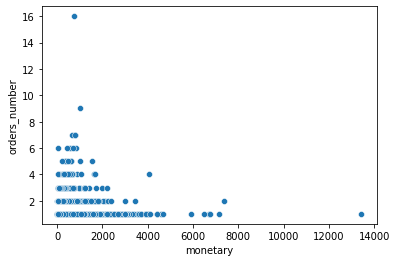

In [39]:
import seaborn as sns
sns.scatterplot(x = 'monetary', y = 'orders_number', data = rfm)

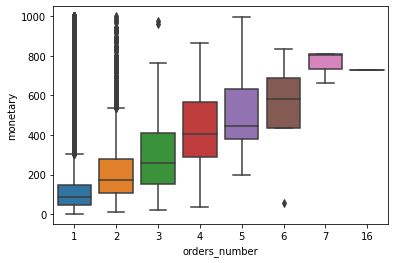

In [40]:
sns.boxplot(x='orders_number', y='monetary', data=rfm.query('monetary<1000')) 

In [41]:
rfm.describe(percentiles=[.10, .25, .75, .80, .90, .95])

,churn_time,orders_number,monetary
count,94970,94970.000000,94970.000000
mean,270 days 18:36:36.617879328,1.033853,142.073605
std,152 days 22:47:54.103938064,0.210801,216.085833
min,28 days 00:00:00,1.000000,0.850000
10%,74 days 00:00:00,1.000000,25.990000
25%,147 days 00:00:00,1.000000,47.900000
50%,252 days 00:00:00,1.000000,89.890000
75%,380 days 00:00:00,1.000000,155.000000
80%,416 days 00:00:00,1.000000,179.900000
90%,499 days 00:00:00,1.000000,281.249000


In [42]:
# Средняя выручка от одного пользователя 142 у.е. При этом половина пользователей принесли до 90 у.е., 30% - 90-180 у.е., 
# 15% - 180-420 у.е. и 5% > 420 у.е. Исходя из этого пределяю границы M - суммы покупок за всё время: 1) >180 хорошие клиенты, 
# таким можно предлагать различные бонусы для поддержания лояльности 2)90-179,9 клиенты со средним чеком, которых особенно надо 
# стимулировать к повторной покупке 3) <90 клиенты с маленькими заказами - есть потенциал к допродаже у поднятию чека.

# Далее определяю параметры F.

In [43]:
# Смотрю количество пользователей customers_number с разным количеством заказов orders_number и размер выручки от них allmoney.
df14=rfm.groupby('orders_number', as_index=False).agg({'monetary':'sum', 'customer_unique_id':'count'})\
        .rename(columns={'monetary':'allmoney', 'customer_unique_id':'customers_number'})
# Считаю в новой колонке % выручки percent от пользователей с разным количеством заказов и их средний чек mean_check.
df14['percent']=df14.allmoney*100/df14.allmoney.sum()
df14['mean_money_from_user']=df14.allmoney/df14.customers_number
df14['mean_check']=df14.mean_money_from_user/df14.orders_number
df14

,orders_number,allmoney,customers_number,percent,mean_money_from_user,mean_check
0,1,1.274253e+07,92084,94.440001,138.379464,138.379464
1,2,6.506913e+05,2650,4.822532,245.543868,122.771934
2,3,6.811118e+04,188,0.504799,362.293511,120.764504
3,4,1.916561e+04,29,0.142044,660.883103,165.220776
4,5,5.616540e+03,9,0.041626,624.060000,124.812000
5,6,2.600660e+03,5,0.019275,520.132000,86.688667
6,7,2.280020e+03,3,0.016898,760.006667,108.572381
7,9,1.000850e+03,1,0.007418,1000.850000,111.205556
8,16,7.296200e+02,1,0.005408,729.620000,45.601250


In [44]:
# По всей вероятности, специфика бизнеса подразумевает большой поток "разовых" клиентов, так как 94,4% выручки принесли клиенты,
# сделавшие всего один заказ. Остальную выручку принесли клиенты, сделавшие большее количество заказов. Средние чеки 
# заказывающих единожды и несколько раз клиентов близки по сумме. Соответственно, если в дальнейшем работать над возвращаемостью
# клиентов, можно кратно увеличить общую выручку. Исходя из этого, границы F - суммарного количества покупок у пользователя за 
# всё время делю на: 1) сделавших более одного заказа(лояльные покупатели) 2)сделавших один заказ(разовые покупатели).

# Далее пробую определить границы R - времени от последней покупки пользователя до текущей даты. Для этого необходимо узнать 
# примерную периодичность покупок у тех, кто совершал их более одного раза.

In [45]:
# Объединяю данные по датам всех заказов у каждого пользователя order_approved_at с количеством заказов orders_number.
df15=df1.merge(f, on='customer_unique_id')\
        .drop(columns={'customer_id','customer_zip_code_prefix','customer_city','customer_state','order_id','order_status',\
                      'order_purchase_timestamp','order_delivered_carrier_date','order_delivered_customer_date',\
                      'order_estimated_delivery_date','monetary'})
df15.head(2)

,customer_unique_id,order_approved_at,order_app,orders_number
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,2017-05,1
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,2018-01,1


In [46]:
# Добавляю текущую дату current_date.
df15['current_date']='2018-10-01'
df15['current_date']=pd.to_datetime(df15['current_date'], format='%Y-%m-%d')
df15['order_approved_at']=pd.to_datetime(df15['order_approved_at'], format='%Y-%m-%d')
df15['order_approved_at']=df15.order_approved_at.dt.strftime('%Y-%m-%d')
df15['order_approved_at']=pd.to_datetime(df15['order_approved_at'], format='%Y-%m-%d')
# добавляю колонку churn_time с количеством дней между текущей датой и датой каждого заказа.
df15['churn_time']=df15['current_date']-df15['order_approved_at']
df15.head(2)

,customer_unique_id,order_approved_at,order_app,orders_number,current_date,churn_time
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16,2017-05,1,2018-10-01,503 days
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12,2018-01,1,2018-10-01,262 days


In [47]:
#считаю кол-во дней между заказами и текущей датой у всех пользователей, сделавших два заказа.
df16=df15.query('orders_number==2').drop(columns={'order_approved_at', 'orders_number', 'current_date'})\
         .sort_values('churn_time', ascending=False)
# сохраняю в новом df16_1 максимальный churn_time для каждого пользователя в days_first .
df16_1=df16.drop_duplicates(subset='customer_unique_id', keep='first').rename(columns={'churn_time':'days_first'})
# сохраняю в новом df16_2 минимальный churn_time для каждого пользователя в days_last .
df16_2=df16.drop_duplicates(subset='customer_unique_id', keep='last').rename(columns={'churn_time':'days_last'})
# Объединяю в одну таблицу days_first с days_last и считаю разницу, равную количеству дней между двумя заказами каждого
# пользователя delta.
df16_3=df16_1.merge(df16_2, on='customer_unique_id')
df16_3['delta']=df16_3.days_first-df16_3.days_last
df16_3.head(2)

,customer_unique_id,order_app_x,days_first,order_app_y,days_last,delta
0,0b3dc7efaafb0cf78a4796d42fa8d74c,2016-10,725 days,2017-07,430 days,295 days
1,4e23e1826902ec9f208e8cc61329b494,2016-10,725 days,2018-03,201 days,524 days


In [48]:
df16_3.describe()

,days_first,days_last,delta
count,2650,2650,2650
mean,337 days 03:48:46.188679244,255 days 19:45:41.433962264,81 days 08:03:04.754716981
std,146 days 05:10:42.635827160,144 days 02:21:14.729690786,111 days 02:51:38.766901488
min,38 days 00:00:00,28 days 00:00:00,0 days 00:00:00
25%,223 days 00:00:00,139 days 00:00:00,0 days 00:00:00
50%,328 days 00:00:00,236 days 00:00:00,28 days 00:00:00
75%,453 days 00:00:00,354 days 00:00:00,126 days 00:00:00
max,725 days 00:00:00,724 days 00:00:00,613 days 00:00:00


In [49]:
# Половина пользователей, сделавших два заказа, совершили последний в течение того же месяца. А еще четверть - в течение 
# последующих четырех месяцев. R - время от последней покупки пользователя до текущей даты буду определять по следующим 
# параметрам: 1) churn_time <= 130дней (у этих клиентов шанс повторной покупки максимален), 2) 130дней <churn_time<=615 дней 
# (есть вероятность повторной продажи), 3) churn_time > 615дней (повторная продажа маловероятна).

In [50]:
# Добавлю коэффициент давности заказа R на основе изучения churn_time.
from datetime import timedelta
delta3 = timedelta(days=615, hours=0, minutes=0)
delta2 = timedelta(days=130, hours=0, minutes=0)
rfm['R']= [3 if x > delta3 else 2 for x in rfm.churn_time]
rfm.loc[rfm.churn_time <= delta2, 'R'] = 1
rfm.head(2)

,customer_unique_id,order_app,churn_time,orders_number,monetary,R
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,144 days,1,129.9,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,147 days,1,18.9,2


In [51]:
rfm.R.unique()

array([2, 1, 3])

In [52]:
# Добавлю индекс количества заказов F на основании orders_number
rfm['F']= [1 if x > 1 else 2 for x in rfm.orders_number]
rfm.head(2)

,customer_unique_id,order_app,churn_time,orders_number,monetary,R,F
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,144 days,1,129.9,2,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,147 days,1,18.9,2,2


In [53]:
rfm.F.unique()

array([2, 1])

In [54]:
# Добавлю коэффициент значения M на основе monetary
rfm['M']= [1 if x >= 180 else 2 for x in rfm.monetary]
rfm.loc[rfm.monetary <90, 'M'] = 3
rfm.head(2)

,customer_unique_id,order_app,churn_time,orders_number,monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,144 days,1,129.9,2,2,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,147 days,1,18.9,2,2,3


In [55]:
rfm.M.unique()

array([2, 3, 1])

In [56]:
# RFM-сегментация пользователей:
rfm

,customer_unique_id,order_app,churn_time,orders_number,monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,144 days,1,129.90,2,2,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,147 days,1,18.90,2,2,3
2,0000f46a3911fa3c0805444483337064,2017-03,570 days,1,69.00,2,2,3
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,354 days,1,25.99,2,2,3
4,0004aac84e0df4da2b147fca70cf8255,2017-11,321 days,1,180.00,2,2,1
...,...,...,...,...,...,...,...,...
94965,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,480 days,1,1570.00,2,2,1
94966,fffea47cd6d3cc0a88bd621562a9d061,2017-12,295 days,1,64.89,2,2,3
94967,ffff371b4d645b6ecea244b27531430a,2017-02,601 days,1,89.90,2,2,3
94968,ffff5962728ec6157033ef9805bacc48,2018-05,152 days,1,115.00,2,2,2
